In [2]:
from pydrake.solvers import MathematicalProgram, Solve, SolverOptions
from pydrake.solvers import IpoptSolver
import numpy as np

# SOLVER OPT

### first way
setting the solver option inside the program. 
PS: this is valid only if i use a particular solver (the same specify in program.SetSolverOption

In [3]:
# with few iteration the program cannot solve nothing 

program = MathematicalProgram()
x = program.NewContinuousVariables(2)
program.AddCost(x[0]**2 + x[1]**2)
program.AddConstraint(x[0] + x[1] == 1)



program.SetSolverOption(IpoptSolver().solver_id(), 'max_iter', 1)
solver = IpoptSolver()
result = solver.Solve(program, np.array([10, 1]), None)

### Second way:
define a solver options and pass this to the solve method


<b>ADVANTAGE</b>: this is indipendent from the program setting

In [4]:
program = MathematicalProgram()
x = program.NewContinuousVariables(2)
program.AddCost(x[0]**2 + x[1] ** 2)
program.AddConstraint(x[0] + x[1] == 1)

<pydrake.solvers.Binding[Constraint] at 0x7f5ab8717eb0>

In [5]:
solver_opt = SolverOptions()
solver_opt.SetOption(IpoptSolver().solver_id(), 'max_iter', 1)
solver = IpoptSolver()

# using max numb of iter
result = solver.Solve(program, np.array([10, 1]), solver_opt)

result = solver.Solve(program, np.array([10, 1]), None)

# UPDATE PARAMS

<b>Control setting</b> ---> solve a new problem at each step :
       update cost funct, constraint etc

## Update cost

### linear cost  (A X + B)

In [6]:
program = MathematicalProgram()
x = program.NewContinuousVariables(2)
# any linear cost : (x.t a) + b
cost1 = program.AddLinearCost(2*x[0] + 3*x[1] + 2)

program.AddBoundingBoxConstraint(-1, 1, x)
result = Solve(program)
result.GetSolution(x), result.get_optimal_cost()

(array([-1., -1.]), -3.0)

In [7]:
cost1.evaluator().UpdateCoefficients(new_a=[3, -4], new_b=5)
print(cost1)
Solve(program).GetSolution(x), Solve(program).get_optimal_cost()

LinearCost (5 + 3 * x(0) - 4 * x(1))


(array([-1.,  1.]), -2.0)

### Quadratic cost ( x.t Q x  +  b x   + c)



In [9]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
cost1 = prog.AddQuadraticCost(
    x[0]**2 + x[0]*x[1] + 2*x[1]**2 +    # Q
    + 3*x[0] +                           # b
    5                                    # c
    )

#
# PS: Q is a symmetric matrix  [a, b]
#                              [b, c]

# general form : [x0, x1] [a, b] [x0]
#                         [b, c] [x1]

cost1.evaluator().UpdateCoefficients(new_Q=[[1., 2.], [2., 4.]], new_b=[1., 2.], new_c=4)

In [10]:
print(cost1)

QuadraticCost (4 + x(0) + 2 * x(1) + (x(0) * (0.5 * x(0) + x(1))) + (x(1) * (x(0) + 2 * x(1))))


# General updating constraint
---> that's mean change problem ??

In [14]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
constraint = prog.AddLinearConstraint(x[0] + 3*x[1] <= 2)
print(constraint)
constraint.evaluator().set_bounds(new_lb=[-5], new_ub=[10])
# result -5 < expression < 10
print(constraint)

LinearConstraint
-inf <= (x(0) + 3 * x(1)) <= 2

LinearConstraint
-5 <= (x(0) + 3 * x(1)) <= 10



# PRO VERSION OF SOLVING

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # extension of matplotlib
from matplotlib import cm                        # color map
from pydrake.solvers import MathematicalProgram
from pydrake.solvers import IpoptSolver
import numpy as np

In [22]:
def constraint(x):
    return [np.cos(x[0]) + 2*np.cos(x[0]-x[1])]

def draw_constraint_landscape(): 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x_mesh, y_mesh = np.meshgrid(np.linspace(-np.pi, np.pi, 31), 
                                 np.linspace(-np.pi, np.pi, 31))
    constraint_val = np.cos(x_mesh) + 2*np.cos(x_mesh-y_mesh)
    surface = ax.plot_surface(x_mesh, y_mesh, constraint_val, cmap=cm.coolwarm, alpha=0.8)
    ax.plot([0], [0], [3], marker='.', color='g', markersize=20)
    ax.set_xlabel('x[0]')
    ax.set_ylabel('x[1]')
    ax.set_zlabel('cost funct')
    fig.show()

    

/tmp/ipykernel_26200/2342633978.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


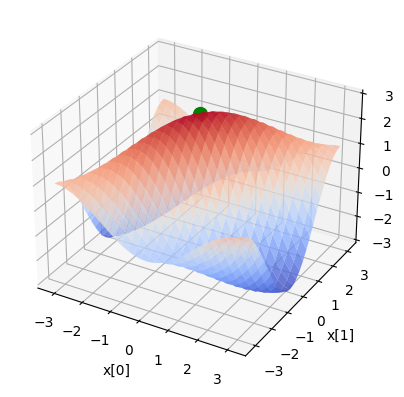

In [23]:
draw_constraint_landscape()

In [26]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "x")

prog.AddConstraint(constraint, [1], [2], x)
solver = IpoptSolver()
prog.SetInitialGuessForAllVariables([0,0])
result = solver.Solve(prog)

In [27]:
#problem: Ipopt it's a gradient solver, and the grad of the cost is 0 
print(f"Starting from x=[0, 0], the solver result is {result.get_solution_result()}")
print(f"The solver gets stuck at x={result.GetSolution(x)}")

Starting from x=[0, 0], the solver result is SolutionResult.kInfeasibleConstraints
The solver gets stuck at x=[0. 0.]


In [28]:
prog.SetInitialGuessForAllVariables([0.1, 0.5])
result = solver.Solve(prog)
print(f"Starting from x=[0, 0], the solver result is {result.get_solution_result()}b")
print(f"The solver gets stuck at x={result.GetSolution(x)}")

Starting from x=[0, 0], the solver result is SolutionResult.kSolutionFound
The solver gets stuck at x=[0.01022453 1.08219118]


In [29]:
print(prog)

Decision variables:x(0) x(1)

PyFunctionConstraint with 2 decision variables x(0) x(1)



# verbosity 

In [32]:
from pydrake.solvers import CommonSolverOption, SolverOptions

prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
# prog.AddConstraint params : funct, lower_bound, upper_bound, varaible
prog.AddConstraint(lambda z: [z.dot(z)], [1], [2], x)
prog.AddConstraint(lambda z: [z[0]**2 + 4*z[0]*z[1] + 4*z[1]**2    + 2*z[0]], [2], [5], x)
prog.SetInitialGuess(x, [0, 0])

# Solver: 
ipopt_solver = IpoptSolver()
filename = "/tmp/debug.txt"
solver_options = SolverOptions()
solver_options.SetOption(CommonSolverOption.kPrintFileName, filename)
result = ipopt_solver.Solve(prog, solver_options=solver_options)


In [33]:
with open(filename) as f:
    print(f.read())

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   3.7006228269558442e-11    3.7006228269558442e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0080321436543615e-11    1.0080321436543615e-11
Overall NLP er